In [ ]:
import os
import shutil
from google.colab import drive
drive.mount("drive/")

Mounted at drive/


In [ ]:
os.chdir("/content/drive/MyDrive/HETIC PFA")

In [ ]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Preparation des données

In [ ]:
!ls

Datasets_images  DeepLabv3+_model.png  Raw_Data
deeplab1.png	 Models		       removed_bg_data


In [ ]:
data_dir = './removed_bg_data'
print(os.listdir(data_dir))

['AD', 'NAD']


## Diviser les données en train test et validation

In [ ]:
filenames = []
for root, dirname, filename in os.walk('/content/drive/MyDrive/HETIC PFA/removed_bg_data'):
  filenames.append(filename)
filenames = [item for sublist in filenames for item in sublist]

In [ ]:
#shutil.rmtree("/content/temp")

In [ ]:
# Decouper les images en train 80%, validation 10% et test 10%
os.chdir("/content/drive/MyDrive/HETIC PFA/removed_bg_data")
data_dir = os.getcwd()
os.mkdir('/content/temp')
os.chdir('/content/temp')
os.mkdir('train')
os.mkdir('validation')
os.mkdir('test')
os.chdir("/content/drive/MyDrive/HETIC PFA/removed_bg_data")
# Split images (80%/10%/10%) and save to temporary folders:
for subfolder in os.listdir(data_dir):

    # Making a list of all files in current subfolder:
    original_path = f'{data_dir}/{subfolder}'
    original_data = os.listdir(original_path)
    print(original_path)
    # Number of samples in each group:
    n_samples = len(original_data)
    train_samples = int(n_samples * 0.8)
    valid_samples = int(n_samples * 0.9)
        
    train_path = f'/content/temp/train/{subfolder}'
    valid_path = f'/content/temp/validation/{subfolder}'
    test_path = f'/content/temp/test/{subfolder}'
    
    # New class subfolder for training:
    os.chdir('/content/temp/train')
    os.mkdir(subfolder)
    
    # Training images:
    for image, filename in zip(range(train_samples), filenames):
        original_file = f'{original_path}/{original_data[image]}'
        new_file = f'{train_path}/{original_data[image]}'
        shutil.copyfile(original_file, new_file)
    
    # New class subfolder for validation:
    os.chdir('/content/temp/validation')
    os.mkdir(subfolder)
    
    # Validation images:
    for image in range(train_samples, valid_samples):
        original_file = f'{original_path}/{original_data[image]}'
        new_file = f'{valid_path}/{original_data[image]}'
        shutil.copyfile(original_file, new_file)
    
    # New class subfolder for testing:
    os.chdir('/content/temp/test')
    os.mkdir(subfolder)
    
    # Test images:
    for image in range(valid_samples, n_samples):
        original_file = f'{original_path}/{original_data[image]}'
        new_file = f'{test_path}/{original_data[image]}'
        shutil.copyfile(original_file, new_file)

/content/drive/MyDrive/HETIC PFA/removed_bg_data/AD
/content/drive/MyDrive/HETIC PFA/removed_bg_data/NAD


In [ ]:
data_dir = '/content/temp'
print(os.listdir(data_dir))

['test', 'validation', 'train']


In [ ]:
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/validation")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')


Train Classes - ['AD', 'NAD']
Validation Classes - ['AD', 'NAD']


In [ ]:
!ls

AD  NAD


In [ ]:
!pwd

/content/temp/test


In [ ]:
os.chdir("/content/drive/MyDrive/HETIC PFA")

# Import du modele pour la prediction des sentiement dans chaque image

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
device = torch.device(device)

In [ ]:
device

device(type='cpu')

In [ ]:
class_labels = ['Fear', 'Sad', 'Happy', 'Disgust', 'Surprise', 'Angry', 'Neutral']

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [ ]:
len(class_labels)

7

In [ ]:
model = to_device(ResNet(1, len(class_labels)), device)
model

In [ ]:
for param in model.parameters():
    print(param.shape)

In [ ]:
model_state = torch.load("./Models/emotion_detection_model_state.pth", map_location=device)
model.load_state_dict(model_state)

<All keys matched successfully>

In [ ]:
data_dir

'/content/temp'

## preparer les données pour la prediction des sentiments

In [ ]:
import torchvision.transforms as tt
tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.Resize((48, 48)), tt.ToTensor() ])

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', tfms)

In [ ]:
test_dataset_normal = ImageFolder(data_dir+'/test', tt.ToTensor())

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    #print(yb[:5].data)#yb.detach().numpy()
    return class_labels[preds[0].item()], yb

# Test, application et prediction des sentiments

Label: AD , Predicted: Disgust


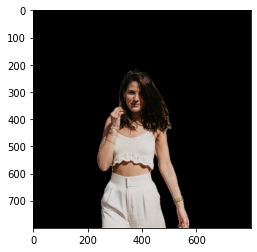

In [ ]:
img, label = test_dataset[0]
img_normal, _ = test_dataset_normal[0]
plt.imshow(np.squeeze(img_normal.permute(1, 2, 0)))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model)[0])

>> TODO for later: ajouter le detecteur de visage et ensuite labeliser les image de facon directe pour tous les images

# Ajout de la fonctionnalité d'associé les sentiment avec des probabilité

In [ ]:
dataset = ImageFolder(os.getcwd()+"/removed_bg_data", tfms)
img, label = dataset[0]
_, output = predict_image(img, model)
print('Predicted sentiment:', predict_image(img, model)[0])
probs = F.softmax(output, dim=1)
print(class_labels)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:].data.tolist())

Predicted sentiment: Happy
['Fear', 'Sad', 'Happy', 'Disgust', 'Surprise', 'Angry', 'Neutral']
Sample probabilities:
 [[0.2853947877883911, 0.005285860039293766, 0.38110148906707764, 0.12351710349321365, 0.05983614921569824, 0.10262921452522278, 0.04223543033003807], [0.2853947877883911, 0.005285860039293766, 0.38110148906707764, 0.12351710349321365, 0.05983614921569824, 0.10262921452522278, 0.04223543033003807], [0.2853947877883911, 0.005285860039293766, 0.38110148906707764, 0.12351710349321365, 0.05983614921569824, 0.10262921452522278, 0.04223543033003807], [0.2853947877883911, 0.005285860039293766, 0.38110148906707764, 0.12351710349321365, 0.05983614921569824, 0.10262921452522278, 0.04223543033003807], [0.2853947877883911, 0.005285860039293766, 0.38110148906707764, 0.12351710349321365, 0.05983614921569824, 0.10262921452522278, 0.04223543033003807], [0.2853947877883911, 0.005285860039293766, 0.38110148906707764, 0.12351710349321365, 0.05983614921569824, 0.10262921452522278, 0.0422354

In [ ]:
proba_list = probs[:].data.tolist()[0]

In [ ]:
proba_list = [np.round(num*100, 2) for num in proba_list]


In [ ]:
proba_list

[28.54, 0.53, 38.11, 12.35, 5.98, 10.26, 4.22]

In [ ]:
dataset_loader = DataLoader(dataset, 1, num_workers=2, pin_memory=True)

In [ ]:
!ls

data_sentiment_dictionary.pkl  deeplab1.png	     Models    removed_bg_data
Datasets_images		       DeepLabv3+_model.png  Raw_Data


In [ ]:
dataset_normal = ImageFolder(os.getcwd()+"/Raw_Data", tt.ToTensor())
dataset_normal_rbg = ImageFolder(os.getcwd()+"/removed_bg_data", tt.ToTensor())

# Enregistrer les images et les sentiments

In [ ]:
dict_to_save = {"raw_images":[],
                "rbg_images":[],
                'images_to_sentiment':[],
                'Fear':[],
                'Sad':[],
                'Happy':[],
                'Disgust':[],
                'Surprise':[],
                'Angry':[],
                'Neutral':[],
                'Label':[]}

for i in range(len(dataset)):
  #load image and its label
  images, labels = dataset[i]
  normal_image, _ = dataset_normal[i]
  rbg_image, _ = dataset_normal_rbg[i]
  # make prediction of the sentiment
  output = predict_image(images, model)[1]
  # probabilité lié à chaque sentiment
  probs = F.softmax(output, dim=1)
  proba_list = probs[:].data.tolist()[0]
  proba_list = [np.round(num*100, 2) for num in proba_list]

  dict_to_save['raw_images'].append(normal_image.cpu().detach().numpy())
  dict_to_save['rbg_images'].append(rbg_image.cpu().detach().numpy())
  dict_to_save['images_to_sentiment'].append(images.cpu().detach().numpy())
  dict_to_save['Fear'].append(proba_list[0])
  dict_to_save['Sad'].append(proba_list[1])
  dict_to_save['Happy'].append(proba_list[2])
  dict_to_save['Disgust'].append(proba_list[3])
  dict_to_save['Surprise'].append(proba_list[4])
  dict_to_save['Angry'].append(proba_list[5])
  dict_to_save['Neutral'].append(proba_list[6])
  dict_to_save['Label'].append(labels)
  #break

In [ ]:
len(dataset)

243

In [ ]:
import pandas as pd

In [ ]:
pd.DataFrame(dict_to_save)

,raw_images,rbg_images,images_to_sentiment,Fear,Sad,Happy,Disgust,Surprise,Angry,Neutral,Label
0,"[[[0.8666667, 0.8666667, 0.8666667, 0.8666667,...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",20.51,0.18,45.78,9.47,4.71,10.26,9.09,0
1,"[[[0.6666667, 0.67058825, 0.6745098, 0.6745098...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",20.17,0.62,22.87,21.94,13.09,18.40,2.90,0
2,"[[[0.68235296, 0.654902, 0.6431373, 0.654902, ...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",10.78,0.34,14.85,42.70,10.36,16.83,4.14,0
3,"[[[0.28627452, 0.28627452, 0.27450982, 0.26274...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",11.78,0.21,14.35,31.01,32.42,9.62,0.61,0
4,"[[[0.627451, 0.627451, 0.627451, 0.62352943, 0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",13.11,0.27,26.05,20.69,16.53,16.33,7.01,0
...,...,...,...,...,...,...,...,...,...,...,...
238,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",20.30,1.45,12.64,25.56,21.44,17.14,1.47,1
239,"[[[0.33333334, 0.35686275, 0.3764706, 0.388235...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",29.71,0.81,33.01,11.59,10.26,11.98,2.63,1
240,"[[[0.91764706, 0.8627451, 0.95686275, 0.694117...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.011764706, 0.05490196, 0.0...",26.30,0.47,19.23,27.80,5.99,12.30,7.91,1
241,"[[[0.011764706, 0.10980392, 0.38431373, 0.4117...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",15.40,0.36,9.49,36.87,20.47,16.18,1.24,1


In [ ]:
dataset.classes[label]#label=0

'AD'

In [ ]:
dataset_normal.classes[label]

'AD'

In [ ]:
import pickle

In [ ]:
with open('data_sentiment_dictionary.pkl', 'wb') as f:
    pickle.dump(dict_to_save, f)

In [ ]:
!pwd

/content/drive/MyDrive/HETIC PFA


In [ ]:
original_label = ["AD", "NAD"]
sentiment_labels = ['Fear', 'Sad', 'Happy', 'Disgust', 'Surprise', 'Angry', 'Neutral']

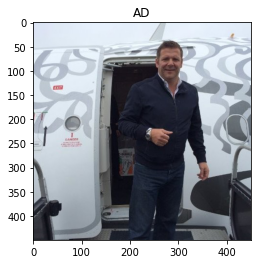

{'Fear': 20.51, 'Sad': 0.18, 'Happy': 45.78, 'Disgust': 9.47, 'Surprise': 4.71, 'Angry': 10.26, 'Neutral': 9.09}


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(dict_to_save['raw_images'][0].transpose(1,2,0))
plt.title(label=original_label[dict_to_save['Label'][0]])
plt.show()
sentiments = tuple(sentiment_labels)
d1 = {k: dict_to_save[k][0] for k in sentiments}
d1
print(d1)

In [ ]:
#dict_to_save
sentiments = tuple(sentiment_labels)
d1 = {k: dict_to_save[k][0] for k in sentiments}
d1

{'Angry': 10.26,
 'Disgust': 9.47,
 'Fear': 20.51,
 'Happy': 45.78,
 'Neutral': 9.09,
 'Sad': 0.18,
 'Surprise': 4.71}

In [ ]:
d = {0:1, 1:2, 2:3, 10:4, 11:5, 12:6, 100:7, 101:8, 102:9, 200:10, 201:11, 202:12}
keys = (0, 1, 2, 100, 101, 102)
d1 = {k: d[k] for k in keys}

In [ ]:
d1

{0: 1, 1: 2, 2: 3, 100: 7, 101: 8, 102: 9}